In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import math
import pandas as pd
from glob import iglob
import numpy as np
import time
from keras.utils import plot_model
from keras.models import load_model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import SGD
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from utils import plot_confusion_matrix
import lime
import lime.lime_tabular

Using TensorFlow backend.


In [2]:
print("Loading training data...")
df = pd.concat((pd.read_csv(f) for f in iglob('../data/**/benign_traffic.csv', recursive=True)), ignore_index=True)

Loading training data...


In [3]:
x_train, x_opt, x_test = np.split(df.sample(frac=1, random_state=17), [int(1/3*len(df)), int(2/3*len(df))])

In [4]:
df_mirai = pd.concat((pd.read_csv(f) for f in iglob('../data/**/mirai_attacks/*.csv', recursive=True)), ignore_index=True)

In [ ]:
df_gafgyt = pd.concat((pd.read_csv(f) for f in iglob('../data/**/gafgyt_attacks/*.csv', recursive=True)), ignore_index=True)

In [ ]:
df_attack = df_mirai.append(df_gafgyt)
df_attack['class'] = 'attack'

In [ ]:
df_fish = x_train.copy()

In [ ]:
df_fish['class'] = 'benign'

In [ ]:
df_fish = df_fish.append(df_attack.sample(n=df_fish.shape[0], random_state=17))

In [ ]:
plot_n = 2000
atk = df_attack.sample(n=plot_n, random_state=76)
nrm = x_train.sample(n=plot_n, random_state=42)

fig, ax1 = plt.subplots()

ax1.scatter(nrm['MI_dir_L0.1_weight'],nrm['MI_dir_L1_weight'],10,c='blue', label='normal',alpha=0.5)
ax1.scatter(atk['MI_dir_L0.1_weight'],atk['MI_dir_L1_weight'],10,c='red',label='attack',alpha=0.5)

plt.xlabel('MI_dir_L0.1_weight')
plt.ylabel('MI_dir_L1_weight')

plt.legend()

In [ ]:
classes = ['benign', 'attack']

In [ ]:
scored = []
indices = {}
shps = {}
for cl in classes:
    indices[cl] = df_fish['class'] == cl
    shps[cl] =  df_fish[indices[cl]].shape[0]
        
for col in df_fish.columns:
    if col == 'class':
        continue
    num = 0
    den = 0
    m = df_fish[col].mean()
    
    for cl in classes:
        num += (shps[cl] / df_fish.shape[0]) * (m - df_fish[indices[cl]][col].mean())**2
        den += (shps[cl] / df_fish.shape[0]) * df_fish[indices[cl]][col].var()
    score = {'feature': col, 'score': num / den}
    scored.append(score)
    #print(score)
scored.sort(key=lambda x: x['score'], reverse=True)
scored[:5]

[{'feature': 'MI_dir_L0.1_weight', 'score': 3.3424566344942805},
 {'feature': 'H_L0.1_weight', 'score': 3.34245638990826},
 {'feature': 'MI_dir_L1_weight', 'score': 3.1793815222225743},
 {'feature': 'H_L1_weight', 'score': 3.1793812343865087},
 {'feature': 'MI_dir_L3_weight', 'score': 3.0088024641835225}]

In [12]:
with open('anomaly_scores.csv', 'w+') as file:
    lines = ['Feature,Score\n']
    for s in scored:
        lines.append(s['feature'] + ',' + "{0:.2f}".format(s['score']) + '\n')
    file.writelines(lines)
        

In [ ]:
def create_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.25 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.5 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.75 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

In [ ]:
class AnomalyModel:
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)

    def scale_predict_classes(self, x):
        x = self.scaler.transform(x)
        y_pred = self.predict(x)
        classes_arr = []
        for e in y_pred:
            el = [0,0]
            el[e] = 1
            classes_arr.append(el)

        return np.array(classes_arr)

In [ ]:
for top_n_features in [115]:
    fs = [it['feature'] for it in scored[:top_n_features]]
    X_train = x_train[fs]
    X_opt = x_opt[fs]
    X_test = x_test[fs]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_opt = scaler.transform(X_opt)
    
    model = create_model(top_n_features)
    model.compile(loss="mean_squared_error",
                    optimizer="adam")
    cp = ModelCheckpoint(filepath=f"anomaly/anomaly{top_n_features}.h5",
                                 monitor='val_loss',
                               save_best_only=True,
                               verbose=0)

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    start = time.time()
    epochs = 100
    history = model.fit(X_train, X_train,
                    epochs=epochs,
                    validation_data=(X_opt, X_opt),
                    verbose=1,
                    callbacks=[cp, es])
    
    end = time.time()
    print('time')
    print(end - start)
    print(model.summary())
    
    x_opt_predictions = model.predict(X_opt)
    mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
    mean = mse.mean()
    std = mse.std()
    
    
    df_benign = pd.DataFrame(x_opt[fs], columns=fs)
    df_benign['malicious'] = 0
    df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=39)[fs]
    df_malicious['malicious'] = 1
    df2 = df_benign.append(df_malicious)
    X_opt = df2.drop(columns=['malicious']).values
    X_opt_scaled = scaler.transform(X_opt)
    
    Y_opt = df2['malicious']
    best_acc = 0
    best_n = 0
    print('Selecting n------------------')
    for n in range(1,11):
        tr = mean + n * std
        m = AnomalyModel(model , tr, scaler)
        Y_pred = m.predict(X_opt_scaled)
        print(f'For n {n}')
        print('Accuracy')
        acc = accuracy_score(Y_opt, Y_pred)
        if acc > best_acc:
            best_acc = acc
            best_n = n
        print(acc)
        print('Precision')
        print(precision_score(Y_opt, Y_pred))
        print('CM')
        print(confusion_matrix(Y_opt, Y_pred))
        #accs.append({'acc': acc, 'n': top_n_features, 'cm': confusion_matrix(Y_test, Y_pred)})
        
    df_benign = pd.DataFrame(X_test, columns=fs)
    df_benign['malicious'] = 0
    df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
    df_malicious['malicious'] = 1
    df2 = df_benign.append(df_malicious)
    X_test = df2.drop(columns=['malicious']).values
    X_test_scaled = scaler.transform(X_test)
    Y_test = df2['malicious']
    
    tr = mean + best_n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_test_scaled)
    print('Test-----------------')
    print(f'best n {best_n}')
    print('Accuracy')
    acc = accuracy_score(Y_test, Y_pred)
    print(acc)
    print('Precision')
    print(precision_score(Y_test, Y_pred))
    print('CM')
    cm = confusion_matrix(Y_test, Y_pred)
    print(cm)   
#print(accs)

Train on 185310 samples, validate on 185311 samples
Epoch 1/100
185310/185310 [==============================] - 24s 128us/step - loss: 0.1436 - val_loss: 0.0767
Epoch 2/100
185310/185310 [==============================] - 25s 136us/step - loss: 0.0654 - val_loss: 0.0527
Epoch 3/100
185310/185310 [==============================] - 26s 138us/step - loss: 0.0514 - val_loss: 0.0453
Epoch 4/100
185310/185310 [==============================] - 25s 133us/step - loss: 0.0457 - val_loss: 0.0409
Epoch 5/100
185310/185310 [==============================] - 25s 134us/step - loss: 0.0425 - val_loss: 0.0405
Epoch 6/100
185310/185310 [==============================] - 26s 139us/step - loss: 0.0403 - val_loss: 0.0372
Epoch 7/100
185310/185310 [==============================] - 25s 136us/step - loss: 0.0377 - val_loss: 0.0369
Epoch 8/100
185310/185310 [==============================] - 25s 137us/step - loss: 0.0362 - val_loss: 0.0339
Epoch 9/100
185310/185310 [==============================] - 26s 138

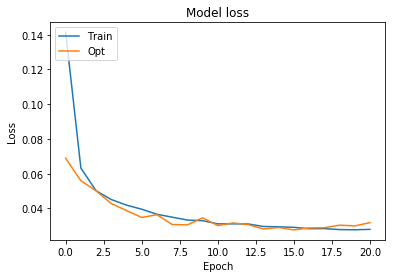

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Opt'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[184998    313]
 [    50 185261]]


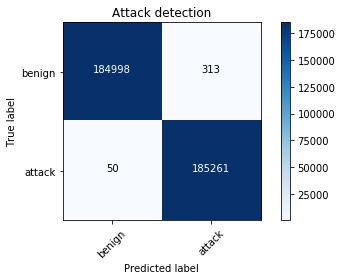

In [17]:
plot_confusion_matrix(cm, classes, title='Attack detection')

In [ ]:
acs = []
params_num = []
best_n = 10
for top_n_features in [3,5,10,20,30,40,50,60,70,80,90,100,115]:
    print("N " + str(top_n_features))
    fs = [it['feature'] for it in scored[:top_n_features]]
    X_train = x_train[fs]
    X_opt = x_opt[fs]
    X_test = x_test[fs]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_opt = scaler.transform(X_opt)
    cp = ModelCheckpoint(monitor='val_loss',
                               save_best_only=True,
                               verbose=0, filepath='temp')
    
    model = create_model(top_n_features)
    model.compile(loss="mean_squared_error",
                    optimizer="adam")

    es = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
    model.fit(X_train, X_train,
                    epochs=50,
                    validation_data=(X_opt, X_opt),
                    verbose=1, callbacks=[es, cp])
    
    
    x_opt_predictions = model.predict(X_opt)
    mse = np.mean(np.power(X_opt - x_opt_predictions, 2), axis=1)
    mean = mse.mean()
    std = mse.std()
    
        
    df_benign = pd.DataFrame(X_test, columns=fs)
    df_benign['malicious'] = 0
    df_malicious = df_attack.sample(n=df_benign.shape[0], random_state=17)[fs]
    df_malicious['malicious'] = 1
    df2 = df_benign.append(df_malicious)
    X_test = df2.drop(columns=['malicious']).values
    X_test_scaled = scaler.transform(X_test)
    Y_test = df2['malicious']
    
    tr = mean + best_n * std
    m = AnomalyModel(model , tr, scaler)
    Y_pred = m.predict(X_test_scaled)
    print('Test-----------------')
    print('Accuracy')
    acc = accuracy_score(Y_test, Y_pred)
    print(acc)
    acs.append(acc)
    params_num.append(model.count_params())
#print(accs)

In [ ]:
plt.xlabel('Features')
plt.ylabel('Accuracy') 
plt.ylim(bottom=0.995)
plt.xticks([3,10,20,30,40,50,60,70,80,90,100,115])
plt.plot([3,5,10,20,30,40,50,60,70,80,90,100,115], acs)

In [ ]:
plt.xlabel('Features')
plt.ylabel('# of parameters')
plt.xlim(3, 115)
plt.xticks([3] + list(range(10,109,10)) + [115])

plt.plot(range(3, 116), params_num)

In [ ]:
#model = load_model('anomaly/anomaly115.h5')

In [ ]:
#plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test, feature_names=fs, class_names=classes, discretize_continuous=True)

In [ ]:
test = df_attack.sample(n=1, random_state=47)[fs].values

exp = explainer.explain_instance(test[0], m.scale_predict_classes, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
m.scale_predict_classes(test)

In [ ]:
exp.as_list()

In [ ]:
",".join(["{0:.2f}".format(s) for s in test[0]])